## Training T5 on Full Dataset

In [ ]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.9 MB/s 
     |████████████████████████████████| 182 kB 81.3 MB/s 
     |████████████████████████████████| 7.6 MB 45.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.9 MB/s 


In [ ]:
from transformers import AdamW, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import T5Tokenizer, T5ForConditionalGeneration


import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

from tqdm.auto import tqdm

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

import re

In [ ]:
data_file_open = open("data_f.txt", 'r', encoding='UTF-8')
label_file_open = open("label_f.txt", 'r', encoding='UTF-8')
data_lines=data_file_open.readlines()
label_lines = label_file_open.readlines()

input_dataset = []
output_dataset = []
dataset = []


for item in data_lines:
    input_dataset.append(item.strip())
for item in label_lines:
    output_dataset.append(item.strip())

In [ ]:
print(len(input_dataset))
print(len(output_dataset))

42535
42535


### This works for both T5 small and base

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
#model = AutoModelWithLMHead.from_pretrained("t5-small", pad_token_id=tokenizer.eos_token_id)
model = T5ForConditionalGeneration.from_pretrained("t5-base")

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
class ShakespeareDataset(Dataset):

    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        x = self.data[index]
        y = self.label[index]
        return_map={"x": x, "y": y}
        return return_map

    def __len__(self):
        return len(self.data)

In [ ]:
dataset = ShakespeareDataset(input_dataset, output_dataset)

In [ ]:
print(len(dataset))

42535


In [ ]:
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=0)

In [ ]:
print(train_dataset[0])

{'x': "There's a greater difference between your flesh and hers than between coal and ivory, and a greater difference between your blood and hers than between red and white wine.", 'y': 'There is more difference between thy flesh and hers than between jet and ivory, more between your bloods than there is between red wine and rhenish.'}


In [ ]:
print(val_dataset[0])

{'x': 'Goodbye.', 'y': 'Farewell.'}


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
print(len(val_dataset))

8507


In [ ]:
optimizer = AdamW(model.parameters(), lr=7e-5)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = model.to(device)

In [ ]:
#for batch in train_dataloader:
#    print(batch['x']['input_ids'].shape)
#    break

In [ ]:
for batch in train_dataloader:
    tokenized_x = tokenizer(batch['x'], padding=True, truncation=True)
    tokenized_y = tokenizer(batch['y'], padding=True, truncation=True)
    print(torch.tensor(tokenized_x['input_ids']))
    #print(batch['y'])
    break

tensor([[   37,    29,   752,    31,     7,   129,   708,    11,   217,    12,
             8,   167,   359,   268,    44,   609,     5,     1,     0,     0,
             0,     0,     0],
        [12325,     3,  4744,    17, 20028,    11,   140,    44,     3,  4744,
            17, 20028,    31,     7,   629,     3,     9,   360,   716,    45,
           230,     5,     1],
        [  466,     3, 14369,    35,     3,  3523,  1106,    60,    40,    55,
             1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  299,   572,   103,    25, 12676,     6,    82, 13414,   520,  1602,
          5981,    58,     1,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  148,    22,    60, 12267,     6,    25,   167, 28617, 11604,     5,
             1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [ 8627,     6,   125,    31,     7,    39,   56

### Model Training

In [ ]:
train_loss_epochs = []
val_loss_epochs = []

In [ ]:
epochs=5

In [ ]:
model = model.to(device)
for epoch in range(epochs):

    print("Epoch:",epoch+1)

    train_loss = 0

    model.train()
    for batch in tqdm(train_dataloader):

        # Tokenization done for individual batches
        tokenized_x = tokenizer(batch['x'], padding=True, truncation=True)
        tokenized_y = tokenizer(batch['y'], padding=True, truncation=True)

        input_ids = torch.tensor(tokenized_x['input_ids']).to(device)
        attention_mask = torch.tensor(tokenized_x['attention_mask']).to(device)
        output_ids = torch.tensor(tokenized_y['input_ids']).to(device)

        output_ids[output_ids == tokenizer.pad_token_id] = -100

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=output_ids)
        loss = outputs.loss

        train_loss += loss
        train_loss = train_loss.detach()

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

    print("Training Loss =",train_loss.cpu()/len(train_dataloader))

    train_loss_epochs.append(train_loss.cpu()/len(train_dataloader))



    val_loss = 0

    model.eval()
    for batch in tqdm(val_dataloader):

        tokenized_x = tokenizer(batch['x'], padding=True, truncation=True)
        tokenized_y = tokenizer(batch['y'], padding=True, truncation=True)

        input_ids = torch.tensor(tokenized_x['input_ids']).to(device)
        attention_mask = torch.tensor(tokenized_x['attention_mask']).to(device)
        output_ids = torch.tensor(tokenized_y['input_ids']).to(device)

        output_ids[output_ids == tokenizer.pad_token_id] = -100


        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=output_ids)
            val_loss += outputs.loss

    print("Validation Loss =",val_loss/len(val_dataloader))

    val_loss_epochs.append(val_loss.cpu()/len(val_dataloader))

Epoch: 1


  0%|          | 0/4254 [00:00<?, ?it/s]

Training Loss = tensor(1.6697)


  0%|          | 0/1064 [00:00<?, ?it/s]

Validation Loss = tensor(1.8627, device='cuda:0')
Epoch: 2


  0%|          | 0/4254 [00:00<?, ?it/s]

Training Loss = tensor(1.5608)


  0%|          | 0/1064 [00:00<?, ?it/s]

Validation Loss = tensor(1.8726, device='cuda:0')


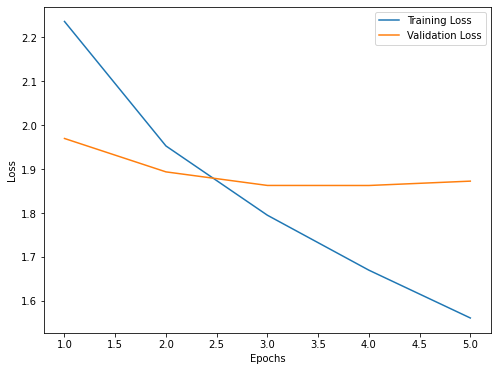

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(torch.arange(1,6) , train_loss_epochs, label='Training Loss');
plt.plot(torch.arange(1,6) , val_loss_epochs, label='Validation Loss');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend();

In [ ]:
print(train_loss_epochs)
print(val_loss_epochs)

[tensor(2.2364), tensor(1.9528), tensor(1.7949), tensor(1.6697), tensor(1.5608)]
[tensor(1.9698), tensor(1.8937), tensor(1.8628), tensor(1.8627), tensor(1.8726)]


In [ ]:
input_text="Hello, how are you?"
input = tokenizer.encode(input_text)
output = model.generate(input_ids=torch.tensor([input]).to(device), max_new_tokens=20, do_sample=False, temperature=1.2)
print(input_text)
print(tokenizer.decode(output[0], skip_special_tokens=True))

Hello, how are you?
How now!


In [ ]:
input_text="Now, beautiful Hippolyta , the hour of our wedding is speeding closer."
input = tokenizer.encode(input_text)
output = model.generate(input_ids=torch.tensor([input]).to(device), do_sample=False, temperature=1.1)
print(input_text)
print(tokenizer.decode(output[0], skip_special_tokens=True))

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Now, beautiful Hippolyta , the hour of our wedding is speeding closer.
Now, fair Hippolyta, The hour of our wedding draws near.


### Saving model in Drive

In [ ]:
torch.save(model.state_dict(), '/content/t5-base_7e-5lr_5epochs')

In [ ]:
from google.colab import drive

import shutil

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
shutil.copy("/content/t5-base_7e-5lr_5epochs","/content/drive/MyDrive/ECE1786_Project/Models/T5_Base_Models")

'/content/drive/MyDrive/ECE1786_Project/Models/T5_Base_Models/t5-base_7e-5lr_5epochs'